## Clasificador de SPAM con RNN. ##

Instrucciones: construir una red neuronal recurrente para clasificar los correos de Spam en la base de datos en Enron.

**Librerias:**

In [ ]:
#pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from sklearn.model_selection import train_test_split

#Tokenizer
#import sentencepiece as spm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

**Cargar datos:**

In [3]:
data = pd.read_csv('./Data/spam_enron1.csv', low_memory=False)

**Preprocesamiento: analisis y limpieza de datos:**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [5]:
data.isna().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [6]:
data = data.drop(columns=['Unnamed: 0'])
data = data.dropna()

In [7]:
data['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [8]:
data['label_num'].value_counts()

label_num
0    3672
1    1499
Name: count, dtype: int64

In [9]:
data

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


**Preprocesar texto:**

In [10]:
stop_words = set(stopwords.words("english"))
html_tags_pattern = re.compile(r'<.*?>')

In [11]:
def text_cleaner(text):
    """
    Clean text column in the dataset.
    """
    # Remove HTML tags
    new_string =  re.sub(html_tags_pattern, '', text)
    # Remove quotes
    new_string = re.sub(r'"', "", new_string)
    # Expand contractions using the dictionary
    new_string = contractions.fix(new_string)
    # Remove possessive 's
    new_string = re.sub(r"'s\b", "", new_string)
    # Lowercase words
    new_string = new_string.lower()
    # Remove non-alphabetic characters and short words, filter stop words
    tokens = [
        w
        for w in re.findall(r"\b\w+\b", new_string)
        if len(w) >= 3 and w not in stop_words
    ]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join long words
    cleaned_text = " ".join(tokens).strip()
    
    return cleaned_text


##Función creada por colegio-bourbaki.com

In [12]:
data["text"] = data["text"].apply(text_cleaner)

In [13]:
data.head(3)

,label,text,label_num
0,ham,subject enron methanol meter 988291 follow not...,0
1,ham,subject hpl nom january 2001 see attached file...,0
2,ham,subject neon retreat around wonderful time yea...,0


**Distribucción de las palabras:**

In [14]:
review_words = data["text"].apply(lambda x: len(str(x).split()))

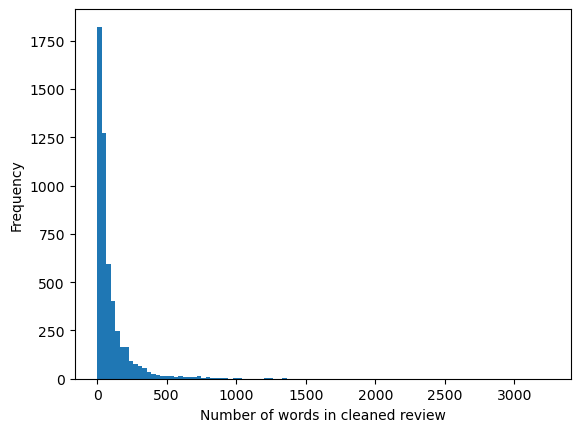

In [15]:
review_words.plot.hist(bins=100)
plt.xlabel("Number of words in cleaned review")
plt.show()

In [16]:
review_words.describe()

count    5171.000000
mean       97.489847
std       146.510418
min         1.000000
25%        23.000000
50%        49.000000
75%       111.000000
max      3244.000000
Name: text, dtype: float64

In [17]:
all_text = ' '.join(data['text'])
rev_unique_words = set(all_text.split())
rev_unique_words = len(rev_unique_words)
print(f"Total de palabras únicas: {rev_unique_words}")

Total de palabras únicas: 47263


In [62]:
p=0.9
print(f"El {100*p:.0f}% de los textos tiene {review_words.quantile(p):.0f} palabras")

El 90% de los textos tiene 227 palabras


**Tokenización:**

In [19]:
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])

**Padding:**

In [20]:
padded_sequences = pad_sequences(sequences, maxlen=10, padding='post')

**División de conjunto de entrenamiento y de validación:**

80%  - 20%

In [23]:
split = int(len(padded_sequences) * 0.8)
x_train, x_test = padded_sequences[:split], padded_sequences[split:]
y_train, y_test = data['label_num'][:split], data['label_num'][split:] #4136

In [24]:
print(
    f"Hay {len(x_train)} textos en el conjunto de entrenamiento y {len(x_test)} textos en el conjunto de prueba"
)

Hay 4136 textos en el conjunto de entrenamiento y 1035 textos en el conjunto de prueba


In [95]:
x_train_pd = pd.DataFrame(x_train)
x_test_pd = pd.DataFrame(x_test)

In [96]:
x_train_pd.to_csv('./Data/x_train.csv', index=False, header=False)
x_test_pd.to_csv('./Data/x_test.csv', index=False, header=False)

In [97]:
y_train_pd = pd.DataFrame(y_train)
y_test_pd = pd.DataFrame(y_test)

In [98]:
y_train_pd.to_csv('./Data/y_train.csv', index=False, header=False)
y_test_pd.to_csv('./Data/y_test.csv', index=False, header=False)

**Creación de modelo:**

Notas:
* Número de palabras en el vocabulario, vectores de 16 dimensiones
* # 32 unidades en la capa RNN
* Capa de salida para clasificación binaria dado que solo hay dos clasificaciones posibles.

In [86]:
model = Sequential([
    Embedding(input_dim=25000, output_dim=2, input_length=10),
    SimpleRNN(16), 
    Dense(1, activation='sigmoid')  
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 10, 2)             50000     
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 16)                304       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 50321 (196.57 KB)
Trainable params: 50321 (196.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
history = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

Epoch 1/8
130/130 [==============================] - 1s 2ms/step - loss: 0.5576 - accuracy: 0.7251 - val_loss: 0.4095 - val_accuracy: 0.7865
Epoch 2/8
130/130 [==============================] - 0s 1ms/step - loss: 0.2199 - accuracy: 0.9144 - val_loss: 0.2118 - val_accuracy: 0.9082
Epoch 3/8
130/130 [==============================] - 0s 1ms/step - loss: 0.0819 - accuracy: 0.9746 - val_loss: 0.1982 - val_accuracy: 0.9140
Epoch 4/8
130/130 [==============================] - 0s 1ms/step - loss: 0.0379 - accuracy: 0.9906 - val_loss: 0.1838 - val_accuracy: 0.9314
Epoch 5/8
130/130 [==============================] - 0s 1ms/step - loss: 0.0187 - accuracy: 0.9964 - val_loss: 0.2107 - val_accuracy: 0.9179
Epoch 6/8
130/130 [==============================] - 0s 1ms/step - loss: 0.0110 - accuracy: 0.9983 - val_loss: 0.2230 - val_accuracy: 0.9285
Epoch 7/8
130/130 [==============================] - 0s 1ms/step - loss: 0.0073 - accuracy: 0.9993 - val_loss: 0.2727 - val_accuracy: 0.9188
Epoch 8/8
130

**Evaluación:**

In [88]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

33/33 [==============================] - 0s 656us/step - loss: 0.2241 - accuracy: 0.9227
Test Loss: 0.22412675619125366
Test Accuracy: 0.9227052927017212


**Predicción:**

In [89]:
predictions = model.predict(x_test)
print('Predictions:', predictions)


33/33 [==============================] - 0s 628us/step
Predictions: [[0.00220071]
 [0.00200189]
 [0.7488756 ]
 ...
 [0.00097575]
 [0.00159991]
 [0.78430045]]


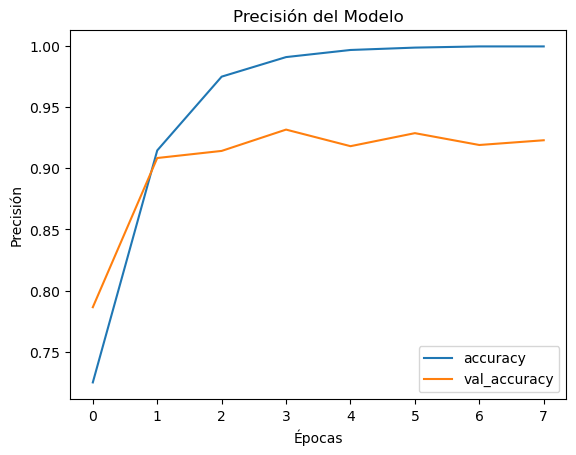

In [90]:
# Precisión (Accuracy)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend(loc='lower right')
plt.show()


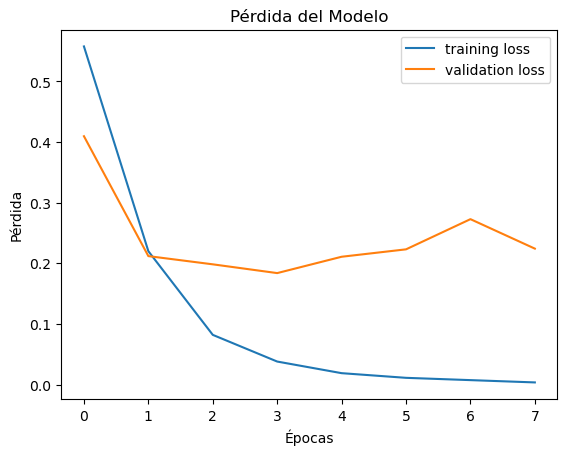

In [91]:
# Pérdida (Loss)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Pérdida del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.show()